In [1]:
# evaluation of models on the test set

import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt

from platt_scaling import platt_scaling_fit
from conformal_pred_algos import *
from conformal_pred_metrics import *

In [2]:
# experimental settings
dataset = 'CIFAR'#'TMED'/'CIFAR'/'AS'
MAP_TO_STUDY_LEVEL = False

In [3]:
# start by obtaining, for each method, the validation and test prediction logits
methods = ['Default', 'LE=1', 'LE=2']
if dataset == 'TMED':
    log_root = "../logs/R18_tmed/"
    val_csvs = ["round0/csvs/val_6_0.59.csv", "round1/csvs/val_18_0.59.csv", "round2/csvs/val_15_0.60.csv"]
    test_csvs = ["round0/csvs/test_30_0.55.csv", "round1/csvs/test_30_0.55.csv", "round2/csvs/test_30_0.57.csv"]
elif dataset == 'CIFAR':
    log_root = '../logs/R18_cifar_smaller_val/'
    val_csvs = ['round0/csvs/val_2_0.75.csv', 'round1/csvs/val_8_0.77.csv', 'round2/csvs/val_8_0.77.csv']
    test_csvs = ['round0/csvs/test_10_0.74.csv', 'round1/csvs/test_10_0.76.csv', 'round2/csvs/test_10_0.77.csv']
elif dataset == 'AS':
    methods = ['Default', 'LE=1']
    log_root = '../logs/AS_Prev/'
    val_csvs = ['round0/csvs/val_17.csv', 'round1/csvs/val_13.csv']
    test_csvs = ['round0/csvs/test_0.csv', 'round1/csvs/test_0.csv']
    data_info_df = pd.read_csv("../logs/AS_Prev/annotations-all.csv")
    data_info_df['base_id'] = data_info_df['path'].apply(os.path.basename)
val_csvs = [log_root + m for m in val_csvs]
test_csvs = [log_root + m for m in test_csvs]

In [4]:
# collect the dataframes
df_val = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in val_csvs]
df_test = [pd.read_csv(x).sort_values(by=['filename']).reset_index() for x in test_csvs]

In [5]:
df_val[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,outputs_5,outputs_6,outputs_7,outputs_8,outputs_9
0,0,0,0,2,-3.001708,-3.576829,1.961566,2.532536,1.490982,1.187150,4.152256,-0.315097,-3.347448,-6.132422
1,1,1,1,2,-5.085364,-2.291695,1.710982,3.207811,2.806079,2.597799,2.508767,-0.193195,-6.172404,-4.230563
2,2,2,2,2,-1.083707,-2.971695,4.539859,0.282981,2.148135,1.377571,-1.043147,-1.375022,-3.449902,-2.822930
3,3,3,3,2,-0.613623,-2.375404,6.087807,-1.348315,1.907314,0.004485,1.560015,-2.022348,-2.452760,-5.200134
4,4,4,4,9,1.994644,0.411160,-2.455649,-2.071070,-4.160336,-2.869025,-4.015794,1.097073,1.004520,6.329980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,9995,1,0.195229,13.884732,-3.641811,-2.303909,-2.230237,-2.974793,-5.790798,-1.826558,-0.143492,2.644449
9996,9996,9996,9996,1,3.491110,4.470566,-4.962294,-2.465844,-5.342498,-4.389783,-7.842149,-0.777049,3.676502,9.883956
9997,9997,9997,9997,1,3.829250,3.754202,-3.131140,-2.295289,-2.423538,-2.705829,-6.408394,0.513103,3.535192,3.680714
9998,9998,9998,9998,1,4.350280,3.105906,1.520656,1.144718,-3.755720,0.959710,-5.070094,-3.218049,1.852301,-3.228741


In [6]:
def studyinfo_from_query_key(s):
    # Define the regular expression pattern
    pattern = r'(\d+)s(\d+)_(\d+)\.png'
    
    # Use re.match to search for the pattern in the string
    match = re.match(pattern, s)
    
    # If a match is found, extract the groups and return them as a tuple
    if match:
        ID, studyNum, imageNum = match.groups()
        #return int(ID), int(studyNum), int(imageNum)
        return str(ID) + '_' + str(studyNum)
    else:
        return None
    
def search_for_study_id_AS(uid):
    # look for uid match in the AS database, then find the echo ID#
    base_id = os.path.basename(uid)
    row = data_info_df[data_info_df['base_id']==base_id]['Echo ID#']
    if len(row) > 1:
        print(row)
        assert False
    return int(row.values[0])

def find_study_id(uids, mode='TMED'):
    # uids is a pd.series of unique identifiers
    # returns a pd.series of study IDs
    if mode == 'TMED':
        basenames = uids.apply(os.path.basename)
        study_nums = basenames.apply(studyinfo_from_query_key)
    elif mode == 'CIFAR':
        study_nums = uids // 4
    elif mode == 'AS':
        study_nums = uids.apply(search_for_study_id_AS)
    return study_nums

find_study_id(df_val[0]['filename'], mode=dataset).unique()

array([   0,    1,    2, ..., 2497, 2498, 2499])

In [7]:
def group_logits_by_study(df, mode='TMED'):
    cols = [x for x in df.columns if 'outputs' in x]
    new_df = {'y':[], 'uid':[]}
    for c in cols:
        new_df[c] = []
    
    study_nums = find_study_id(df['filename'], mode=mode)
    for s in study_nums.unique():
        dfs = df[study_nums == s]
        new_df['y'].append(dfs.iloc[0]['y'])
        new_df['uid'].append(s)
        # average the logits
        for c in cols:
            new_df[c].append(np.mean(dfs[c]))
            
    return pd.DataFrame.from_dict(new_df)

if MAP_TO_STUDY_LEVEL:
    df_val = [group_logits_by_study(v, dataset) for v in df_val]
    df_test = [group_logits_by_study(v, dataset) for v in df_test]


In [8]:
def df_to_logits(df):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    return logits

test_logits = [df_to_logits(x) for x in df_test]
val_logits = [df_to_logits(x) for x in df_val]

In [9]:
# compute the top-1 balanced accuracy
for i in range(len(methods)):
    val_gt, test_gt = df_val[i]['y'], df_test[i]['y']
    val_pred = np.argmax(val_logits[i], axis=1)
    test_pred = np.argmax(test_logits[i], axis=1)
    val_acc = balanced_accuracy_score(val_gt, val_pred)
    test_acc = balanced_accuracy_score(test_gt, test_pred)
    print(f"Method: {methods[i]}, balanced top-1 acc (val/test) = {val_acc}/{test_acc}")
    print(confusion_matrix(val_gt, val_pred))
    print(confusion_matrix(test_gt, test_pred))

Method: Default, balanced top-1 acc (val/test) = 0.7504196928801212/0.7431
[[794   6  31  14  13   2   4  11  65  36]
 [ 44 796   3  14   5   8   3  11  30  74]
 [ 52   7 595  70  65  39  48  33  20   7]
 [ 22   4  37 743  35 148  48  22   9  12]
 [ 13   0  57  34 635  26  40  61   7   3]
 [  9   2  31 190  38 659  15  49   5   6]
 [  8   1  52  54  41  13 817   8  11   3]
 [  8   1  40  34  84  49   7 719   9  13]
 [ 88  30   8  18  10   5   6  11 910  50]
 [ 30  65   7  12   9   4   7  19  30 849]]
[[3160   40  129   71   59   29   29   64  265  154]
 [ 136 3177   31   55   34   22   19   30  116  380]
 [ 215   13 2617  266  328  154  240   88   53   26]
 [ 102   35  186 2613  153  498  176  139   49   49]
 [  54    9  247  188 2919  144  195  184   47   13]
 [  44   16  130  733  170 2603   82  169   25   28]
 [  38   14  200  236  189   78 3190   23   18   14]
 [  64   18  116  185  320  175   35 3007   33   47]
 [ 344   84   43   56   58   19   22   36 3144  194]
 [ 139  229   14 

In [10]:
def get_calibration_data(sm, y):
    # sm is N, C softmax output
    # compute the accuracy of each confidence decile
    confidences = np.max(sm, axis=1)
    preds = np.argmax(sm, axis=1)
    #print(confidences)
    confidence_hist, bin_edges = np.histogram(confidences, bins=np.arange(11)/10)
    #print(confidence_hist)
    #print(bin_edges)
    bin_association = np.digitize(confidences, bins=bin_edges)
    #print(np.unique(bin_association))
    calibration_x = []
    calibration_y = []
    ECE = 0
    for i in range(10):
        subset = bin_association == (i+1)
        if confidence_hist[i] > 0:
            acc = accuracy_score(y[subset], preds[subset])
            calibration_x.append(i)
            calibration_y.append(acc)
            #print(np.mean(confidences[subset]))
            # calculate ECE
            ECE += confidence_hist[i] * np.abs(acc - np.mean(confidences[subset]))
    ECE = ECE / len(y)
    
    return calibration_x, calibration_y, ECE
    
# sanity check: calibrating on yourself gets a low ECE
platt_coeffs = platt_scaling_fit(val_logits[0], df_val[0]['y'], mode="temp")
vsm = softmax(val_logits[0], axis=1)
vsm_platt = softmax(val_logits[0]*platt_coeffs, axis=1)
get_calibration_data(vsm_platt, df_val[0]['y'])

([1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0.3333333333333333,
  0.3054187192118227,
  0.35625,
  0.4718162839248434,
  0.5440647482014388,
  0.6328205128205128,
  0.7667304015296367,
  0.8438247011952191,
  0.9697766097240473],
 0.008317930287528323)

In [11]:
# compute the top-1 calibration
cal_x_arr, cal_y_arr, ece_arr = [], [], []
for i in range(len(methods)):
    platt_coeffs = platt_scaling_fit(val_logits[i], df_val[i]['y'], mode="platt")
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    cal_x, cal_y, ece = get_calibration_data(test_sm, df_test[i]['y'])
    cal_x_arr.append(cal_x)
    cal_y_arr.append(cal_y)
    ece_arr.append(ece)
    
    cal_x, cal_y, ece_platt = get_calibration_data(test_sm_platt, df_test[i]['y'])
    cal_x_arr.append(cal_x)
    cal_y_arr.append(cal_y)
    ece_arr.append(ece_platt)
    print(f"Method {methods[i]}, ECE wo Platt: {ece} ECE w Platt: {ece_platt}")

Method Default, ECE wo Platt: 0.036680457742955475 ECE w Platt: 0.04260482864198996
Method LE=1, ECE wo Platt: 0.03949963739230159 ECE w Platt: 0.03842415933727947
Method LE=2, ECE wo Platt: 0.09948673904744873 ECE w Platt: 0.03942534820325492


['Default, ECE=0.04', 'Default(P), ECE=0.04', 'LE=1, ECE=0.04', 'LE=1(P), ECE=0.04', 'LE=2, ECE=0.10', 'LE=2(P), ECE=0.04']
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2222222222222222, 0.23865546218487396, 0.3410931174089069, 0.43025309005297235, 0.49299649824912456, 0.6007442849548112, 0.679379274066281, 0.7931246163290362, 0.9537690731040765]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.1875, 0.24680073126142596, 0.31827309236947793, 0.4151959317977864, 0.5105580693815988, 0.5854290899662951, 0.6758394344862408, 0.7872683319903304, 0.9464882943143813]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.1935483870967742, 0.27547169811320754, 0.38130217028380636, 0.47362195410456587, 0.6030262572318648, 0.7142177841179268, 0.8191657271702367, 0.9081808767690714, 0.9821288603229347]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.0, 0.2414448669201521, 0.3309752400202122, 0.43679858239810987, 0.5279052911331239, 0.6242021955578249, 0.7063966866083755, 0.8098901098901099, 0.9208597647348649]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.21739130434782608, 0.2991689

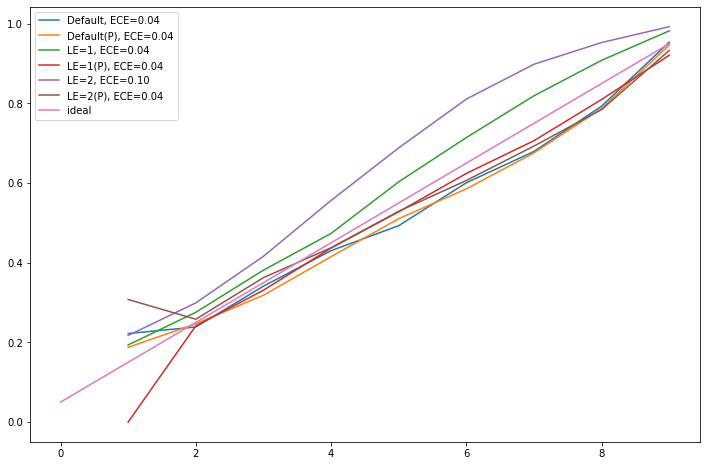

In [12]:
def plot_calibration(x_arr, y_arr, names):
    plt.figure(figsize=(12,8))
    for i in range(len(x_arr)):
        print(x_arr[i])
        print(y_arr[i])
        plt.plot(x_arr[i], y_arr[i])
    plt.plot(np.arange(10), np.arange(10)/10 + 0.05)
    plt.legend(names + ['ideal'])
    plt.show()
    
names = []
for i in range(len(ece_arr)):
    method = methods[i//2]
    ece = ece_arr[i]
    if i % 2 == 0:
        names.append("{}, ECE={:.2f}".format(method, ece))
    else:
        names.append("{}(P), ECE={:.2f}".format(method, ece))
print(names)
plot_calibration(cal_x_arr, cal_y_arr, names)

In [17]:
# Conformal prediction using LABEL
for i in range(len(methods)):
    print(methods[i])
    y_test = df_test[i]['y'].to_numpy(dtype=int)
    y_val = df_val[i]['y'].to_numpy(dtype=int)
    platt_coeffs = platt_scaling_fit(val_logits[i], y_val, mode="platt")
    
    val_sm = softmax(val_logits[i], axis=1)
    val_sm_platt = softmax(val_logits[i]*platt_coeffs, axis=1)
    
    test_sm = softmax(test_logits[i], axis=1)
    test_sm_platt = softmax(test_logits[i]*platt_coeffs, axis=1)
    
    
    alphas = [0.05]
    for a in alphas:
        print(f"alpha={a}")
        for platt in [False, True]:
            if platt:
                qhat = group_APS_fit(y_val, y_val, val_sm_platt, alpha=a, verbose=False)
                cs = group_APS_inference(test_sm_platt, y_test, qhat)
                #qhat = APS_fit(y_val, val_sm_platt, alpha=a, verbose=False)
                #cs = APS_inference(test_sm_platt,  qhat)
            else:
                qhat = group_APS_fit(y_val, y_val, val_sm, alpha=a, verbose=False)
                cs = group_APS_inference(test_sm, y_test, qhat)
                #qhat = APS_fit(y_val, val_sm, alpha=a, verbose=False)
                #cs = APS_inference(test_sm,  qhat)
                
            cov = coverage_test(y_test, cs)
            bcov = balanced_coverage_test(y_test, cs)
            card = cardinality_test(cs)
            if dataset != 'CIFAR':
                print(ordinality_test_arr(cs))
            print(f"Platt({platt}): cov={cov}, bcov={bcov}, card={card}, efficiency={bcov/card}")
        

Default
alpha=0.05
Platt(False): cov=0.950375, bcov=0.950375, card=5.609975, efficiency=0.16940806331579017
Platt(True): cov=0.9508, bcov=0.9507999999999999, card=5.6499, efficiency=0.16828616435689125
LE=1
alpha=0.05
Platt(False): cov=0.94935, bcov=0.9493500000000001, card=4.7478, efficiency=0.19995576898774173
Platt(True): cov=0.94845, bcov=0.94845, card=4.9953, efficiency=0.1898684763677857
LE=2
alpha=0.05
Platt(False): cov=0.95, bcov=0.95, card=4.352475, efficiency=0.21826661841825626
Platt(True): cov=0.948375, bcov=0.9483749999999999, card=4.812525, efficiency=0.1970639113563046


In [14]:
a = [True, True, False, True]
[i for i in range(len(a)) if a[i] == True]

[0, 1, 3]